# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Introduction

Grid algorithms... three alternative:

1. Conjugate priors

2. ABC

3. MCMC



## Generate data

In [4]:
from scipy.stats import norm

data = norm(10, 2).rvs(20)
data

array([ 6.75576472,  6.93212188, 11.9155916 ,  9.67565652, 10.0997749 ,
        7.16107928,  8.30548927, 11.5469982 ,  9.84736686,  7.91236058,
       11.51426586,  7.99245354, 10.04551371, 10.090851  , 11.20064346,
        9.40068495,  9.39336975, 10.57909849,  9.37548161,  4.22141978])

In [5]:
n = len(data)
xbar = np.mean(data)
s2 = np.var(data)

n, xbar, s2

(20, 9.198299297522711, 3.5596169954925143)

## Update

Following notation in Murphy, [Conjugate Bayesian analysis of the Gaussian distribution](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf)

In [6]:
m0 = 0
kappa0 = 0
alpha0 = 0
beta0 = 0

In [7]:
params = (m0, kappa0, alpha0, beta0)

In [8]:
def update_norm_invgamma(params, data):
    m0, kappa0, alpha0, beta0 = params

    n = len(data)
    xbar = np.mean(data)
    s2 = np.var(data)
    
    m_n = (kappa0 * m0 + n * xbar) / (kappa0 + n)
    kappa_n = kappa0 + n

    alpha_n = alpha0 + n/2
    beta_n = beta0 + n*s2/2 + n * kappa0 * (xbar-m0)**2 / (kappa0 + n)  / 2

    return m_n, kappa_n, alpha_n, beta_n

In [9]:
post_params = update_norm_invgamma(params, data)
post_params

(9.198299297522711, 20, 10.0, 35.596169954925145)

In [10]:
m_n, kappa_n, alpha_n, beta_n = post_params

## Posterior marginal distributions

In [11]:
from scipy.stats import invgamma

def make_invgamma(alpha, beta):
    return invgamma(alpha, scale=beta)

In [12]:
dist_sigma2 = make_invgamma(alpha_n, beta_n)

In [13]:
dist_sigma2.mean()

3.9551299949916827

In [14]:
dist_sigma2.std()

1.3983496199664671

In [15]:
sigma2s = np.linspace(0.01, 10, 101)
ps = dist_sigma2.pdf(sigma2s)
posterior_sigma2s = Pmf(ps, sigma2s)

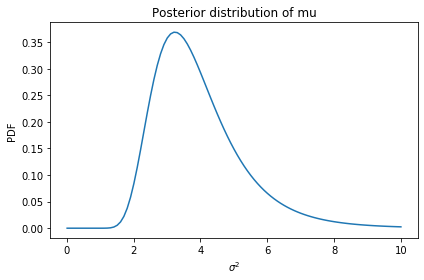

In [16]:
posterior_sigma2s.plot()
decorate(xlabel='$\sigma^2$',
         ylabel='PDF',
         title='Posterior distribution of mu')

In [17]:
from scipy.stats import t

def make_student_t(df, loc, scale):
    return t(df, loc=loc, scale=scale)

In [18]:
df = 2 * alpha_n
precision = alpha_n * kappa_n / beta_n
dist_mu = make_student_t(df, m_n, 1/np.sqrt(precision))

In [19]:
dist_mu.mean()

9.198299297522711

In [20]:
dist_mu.std()

0.44469821199278975

In [21]:
np.sqrt(s2/n)

0.4218777663904863

In [22]:
mus = np.linspace(8, 12, 101)
ps = dist_mu.pdf(mus)
posterior_mus = Pmf(ps, mus)

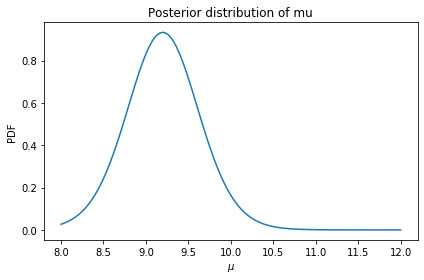

In [23]:
posterior_mus.plot()
decorate(xlabel='$\mu$',
         ylabel='PDF',
         title='Posterior distribution of mu')

## Posterior joint distribution

In [24]:
mu_mesh, sigma2_mesh = np.meshgrid(mus, sigma2s)

In [25]:
joint = dist_sigma2.pdf(sigma2_mesh) * norm(m_n, sigma2_mesh/kappa_n).pdf(mu_mesh)
joint_df = pd.DataFrame(joint, columns=mus, index=sigma2s)

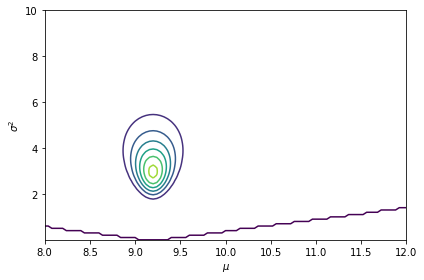

In [26]:
from utils import plot_contour

plot_contour(joint_df)
decorate(xlabel='$\mu$',
         ylabel='$\sigma^2$')

## Sampling from posterior predictive

In [27]:
sample_sigma2 = dist_sigma2.rvs(1000)

In [28]:
sample_mu = norm(m_n, sample_sigma2 / kappa_n).rvs()

In [29]:
sample_pred = norm(sample_mu, np.sqrt(sample_sigma2)).rvs()

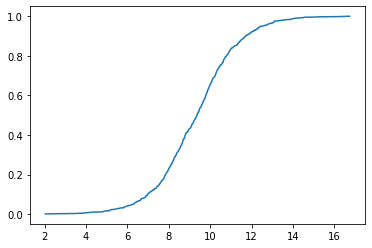

In [30]:
cdf_pred = Cdf.from_seq(sample_pred)
cdf_pred.plot()

In [31]:
sample_pred.mean(), sample_pred.var()

(9.331756592529631, 3.708203291095929)

## Analytic posterior predictive

In [32]:
df = 2 * alpha_n
loc = m_n
precision = alpha_n * kappa_n / beta_n / (kappa_n+1)
dist_pred = make_student_t(df, loc, 1/np.sqrt(precision))

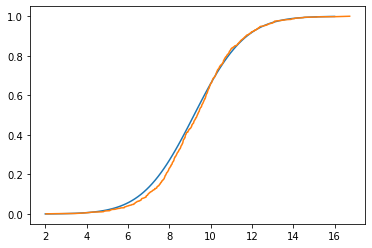

In [33]:
xs = np.linspace(2, 16, 101)
ys = dist_pred.cdf(xs)

plt.plot(xs, ys)
cdf_pred.plot()

## Multivariate normal

## Generate data

In [34]:
mean = [10, 20]

sigma_x = 2
sigma_y = 3
rho = 0.64
cov = rho * sigma_x * sigma_y 

Sigma = [[sigma_x**2, cov], [cov, sigma_y**2]]
Sigma

[[4, 3.84], [3.84, 9]]

In [35]:
from scipy.stats import multivariate_normal

data = multivariate_normal(mean, Sigma).rvs(20)
data

array([[14.13254371, 21.89449976],
       [10.39147343, 19.30082817],
       [ 7.65414603, 19.79101964],
       [ 8.78789094, 17.9745376 ],
       [10.82027066, 17.16019322],
       [11.86487269, 20.17457829],
       [ 9.88278091, 20.26107966],
       [11.28413696, 22.03584472],
       [10.1081241 , 21.21704138],
       [ 9.59389757, 19.95725096],
       [10.92525136, 20.77534273],
       [12.34447692, 22.29280765],
       [ 7.66580774, 17.54461277],
       [ 5.70168648, 15.63241393],
       [10.9130135 , 18.69600598],
       [12.07408785, 23.69784626],
       [12.00470195, 24.15724687],
       [ 9.90985746, 21.98107555],
       [11.71232321, 18.73375311],
       [ 7.53587665, 15.61875601]])

In [36]:
n = len(data)
n

20

In [37]:
xbar = np.mean(data, axis=0)
xbar

array([10.26536101, 19.94483671])

In [38]:
S = np.cov(data.transpose())
S

array([[4.06463106, 3.44115607],
       [3.44115607, 5.80513012]])

In [39]:
np.corrcoef(data.transpose())

array([[1.        , 0.70841512],
       [0.70841512, 1.        ]])

In [142]:
stds = np.sqrt(np.diag(S))
stds

array([2.01609302, 2.40938376])

In [144]:
S / np.outer(stds, stds)

array([[1.        , 0.70841512],
       [0.70841512, 1.        ]])

## Update

Following notation in Murphy, [Conjugate Bayesian analysis of the Gaussian distribution](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf)

In [40]:
m0 = 0
T0 = 0
nu0 = 0
kappa0 = 0

In [41]:
m_n = (kappa0 * m0 + n * xbar) / (kappa0 + n)

In [42]:
d = (m0 - xbar)
D = np.outer(d, d)
D

array([[105.37763659, 204.74094908],
       [204.74094908, 397.79651152]])

In [43]:
T_n = T0 + S + n * kappa0 * D / (kappa0 + n)
T_n

array([[4.06463106, 3.44115607],
       [3.44115607, 5.80513012]])

In [44]:
nu_n = nu0 + n
nu_n

20

In [45]:
kappa_n = kappa0 + n
kappa_n

20

## Posterior marginal distributions

In [126]:
from scipy.stats import invwishart
from scipy.linalg import inv

def make_invwishart(nu, T):
    return invwishart(nu, scale=T)

In [127]:
dist_cov = make_invwishart(nu_n, T_n)

In [129]:
d = 2  # number of dimensions

dist_cov.mean() * (nu_n + d + 1) 

array([[5.49920673, 4.65568174],
       [4.65568174, 7.85399957]])

In [130]:
T_n

array([[4.06463106, 3.44115607],
       [3.44115607, 5.80513012]])

In [134]:
sample = dist_cov.rvs(10)
for T in sample:
    print(np.diag(T))

[0.20480756 0.22996418]
[0.1663531 0.2875968]
[0.18512859 0.2201404 ]
[0.29358995 0.24218165]
[0.27813649 0.40912908]
[0.85139218 0.88894253]
[0.21270496 0.32458046]
[0.30358316 0.36527918]
[0.19318112 0.23112287]
[0.29377026 0.52701816]


In [116]:
num = 31
sigma_xs = np.linspace(0.01, 10, num)
pmf_sigma_xs = Pmf(1, sigma_xs)
pmf_sigma_xs.index.name = 'sigma_x'

In [117]:
sigma_ys = np.linspace(0.01, 10, num)
pmf_sigma_ys = Pmf(1, sigma_ys)
pmf_sigma_ys.index.name = 'sigma_y'

In [118]:
rhos = np.linspace(0, 1, num)
pmf_rhos = Pmf(1, rhos)
pmf_rhos.index.name = 'rho'

In [101]:
from utils import make_joint

joint = make_joint(pmf_sigma_ys, pmf_sigma_xs)
joint = make_joint(pmf_rhos, Pmf(joint.stack()))
joint = Pmf(joint.stack())
joint.head()

sigma_x  sigma_y  rho     
0.01     0.01     0.000000    1
                  0.033333    1
                  0.066667    1
                  0.100000    1
                  0.133333    1
dtype: int64

In [121]:

index = pd.MultiIndex.from_product([sigma_xs, sigma_ys, rhos],
                                   names=['sigma_x', 'sigma_y', 'rho'])
joint = Pmf(0, index)
joint.head()

sigma_x  sigma_y  rho     
0.01     0.01     0.000000    0
                  0.033333    0
                  0.066667    0
                  0.100000    0
                  0.133333    0
dtype: int64

In [122]:
for sigma_x, sigma_y, rho in joint.index:
    cov = rho * sigma_x * sigma_y
    Lambda = [[sigma_x**2, cov], [cov, sigma_y**2]]
    try:
        p = make_invwishart(nu_n, T_n).pdf(Lambda)
    except:
        pass
    joint.loc[sigma_x, sigma_y, rho] = p

In [123]:
joint.sum()

147.3944893934833

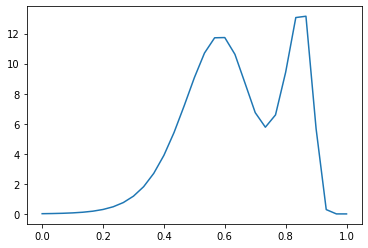

In [124]:
from utils import pmf_marginal

marginal_rho = pmf_marginal(joint, 2)
marginal_rho.plot()

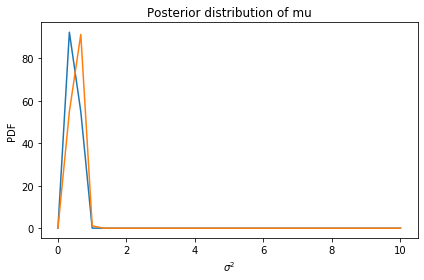

In [125]:
marginal_sigma_x = pmf_marginal(joint, 0)
marginal_sigma_y = pmf_marginal(joint, 1)

marginal_sigma_x.plot()
marginal_sigma_y.plot()

decorate(xlabel='$\sigma^2$',
         ylabel='PDF',
         title='Posterior distribution of mu')

In [52]:
from scipy.stats import t

def make_student_t(df, loc, scale):
    return t(df, loc=loc, scale=scale)

In [53]:
df = 2 * alpha_n
precision = alpha_n * kappa_n / beta_n
dist_mu = make_student_t(df, m_n, 1/np.sqrt(precision))

In [54]:
dist_mu.mean()

array([10.26536101, 19.94483671])

In [55]:
dist_mu.std()

array([0.44469821, 0.44469821])

In [56]:
np.sqrt(s2/n)

0.4218777663904863

In [57]:
mus = np.linspace(8, 12, 101)
ps = dist_mu.pdf(mus)
posterior_mus = Pmf(ps, mus)

ValueError: operands could not be broadcast together with shapes (101,) (2,) 

In [ ]:
posterior_mus.plot()
decorate(xlabel='$\mu$',
         ylabel='PDF',
         title='Posterior distribution of mu')

## Posterior joint distribution

In [ ]:
mu_mesh, sigma2_mesh = np.meshgrid(mus, sigma2s)

In [ ]:
joint = dist_sigma2.pdf(sigma2_mesh) * norm(m_n, sigma2_mesh/kappa_n).pdf(mu_mesh)
joint_df = pd.DataFrame(joint, columns=mus, index=sigma2s)

In [ ]:
from utils import plot_contour

plot_contour(joint_df)
decorate(xlabel='$\mu$',
         ylabel='$\sigma^2$')

## Sampling from posterior predictive

In [ ]:
sample_sigma2 = dist_sigma2.rvs(1000)

In [ ]:
sample_mu = norm(m_n, sample_sigma2 / kappa_n).rvs()

In [ ]:
sample_pred = norm(sample_mu, np.sqrt(sample_sigma2)).rvs()

In [ ]:
cdf_pred = Cdf.from_seq(sample_pred)
cdf_pred.plot()

In [ ]:
sample_pred.mean(), sample_pred.var()

## Analytic posterior predictive

In [ ]:
df = 2 * alpha_n
loc = m_n
precision = alpha_n * kappa_n / beta_n / (kappa_n+1)
dist_pred = make_student_t(df, loc, 1/np.sqrt(precision))

In [ ]:
xs = np.linspace(2, 16, 101)
ys = dist_pred.cdf(xs)

plt.plot(xs, ys)
cdf_pred.plot()